In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [ ]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [29]:
trackers = {}
rets ={}

## MNAR LR 1:2

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-23 09:56:55.143 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 194.6788940000115


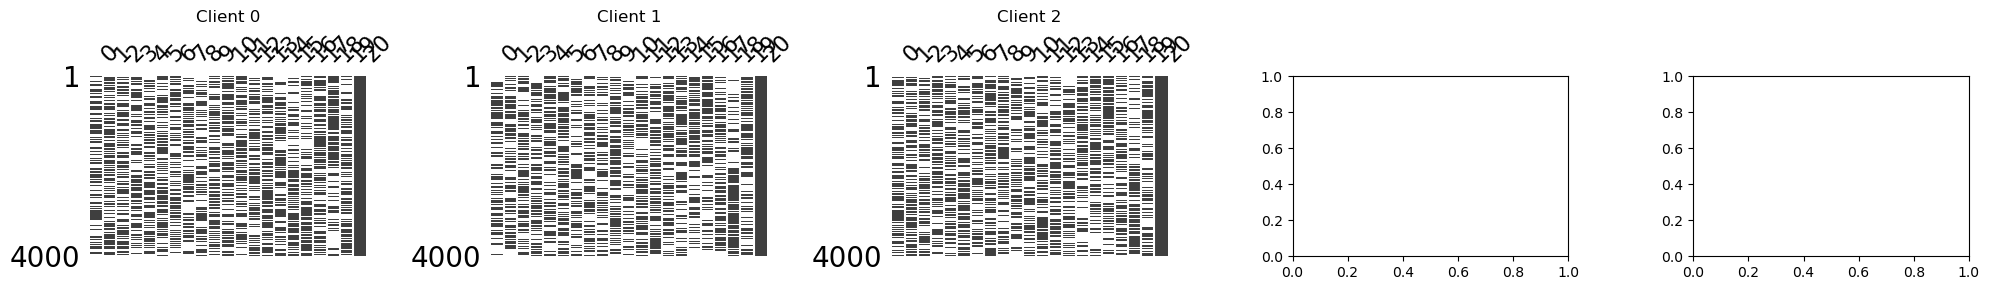

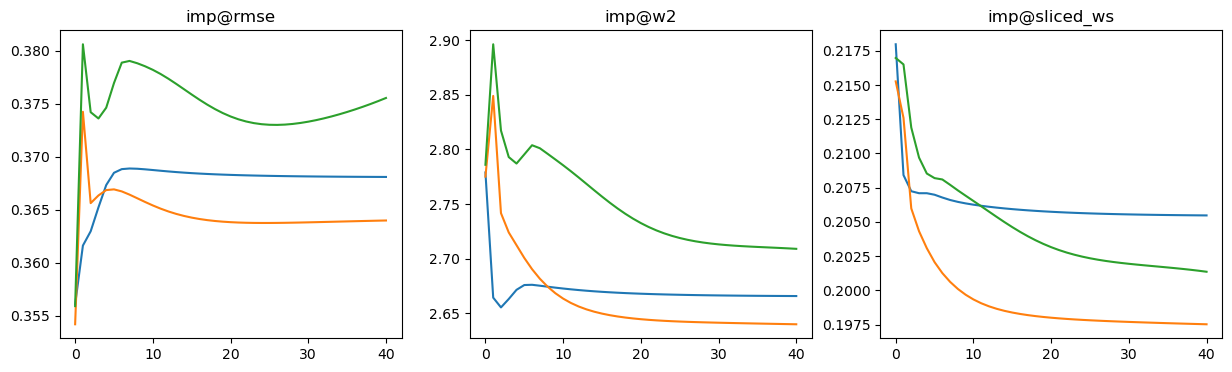

{'imp@rmse': 0.36900201832113816, 'imp@ws': 2.671988062526682, 'imp@sliced_ws': 0.20151167997703592}


In [120]:
name = 'mnar_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [46]:
pred_ret = NN_evaluation(rets['mnar_lr12_local'], type='fedavg', n_rounds=500)

2023-07-21 14:51:27.073 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6423, test_f1: 0.6339, val_loss: 0.6317, val_accu: 0.6379, val_f1: 0.6327
2023-07-21 14:52:32.769 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6387, test_f1: 0.6262, val_loss: 0.6889, val_accu: 0.6242, val_f1: 0.6233
2023-07-21 14:53:38.663 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6132, test_f1: 0.5983, val_loss: 0.7319, val_accu: 0.6121, val_f1: 0.6119
2023-07-21 14:54:45.260 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5979, test_f1: 0.5820, val_loss: 0.7286, val_accu: 0.6100, val_f1: 0.6100
2023-07-21 14:55:50.755 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5918, test_f1: 0.575

0.6950502216993937


In [75]:
pred_ret = NN_evaluation(rets['mnar_lr12_local'], type='centralized', n_rounds=500)

2023-07-22 16:10:38.782 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5079, train_loss: 0.6934 val_accu: 0.5217 val_f1: 0.4090
2023-07-22 16:11:03.953 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.6452, train_loss: 0.6268 val_accu: 0.6533 val_f1: 0.6527
2023-07-22 16:11:31.433 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6219, train_loss: 0.6132 val_accu: 0.6700 val_f1: 0.6694
2023-07-22 16:11:58.319 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6206, train_loss: 0.6050 val_accu: 0.6629 val_f1: 0.6604
2023-07-22 16:12:25.415 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6104, train_loss: 0.5970 val_accu: 0.6675 val_f1: 0.6640


0.6991222513799656


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-23 10:00:20.406 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 190.51993009995203


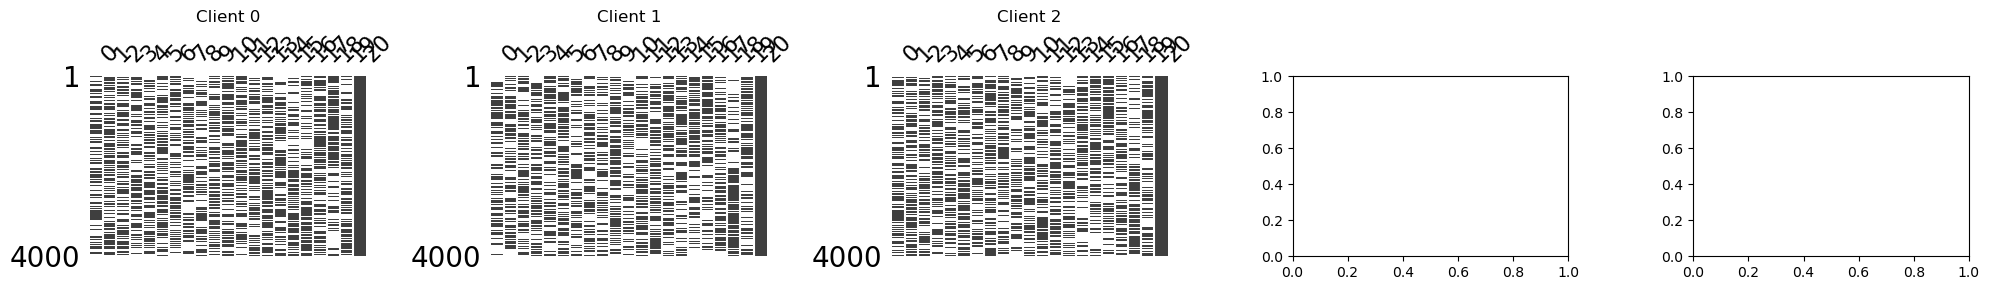

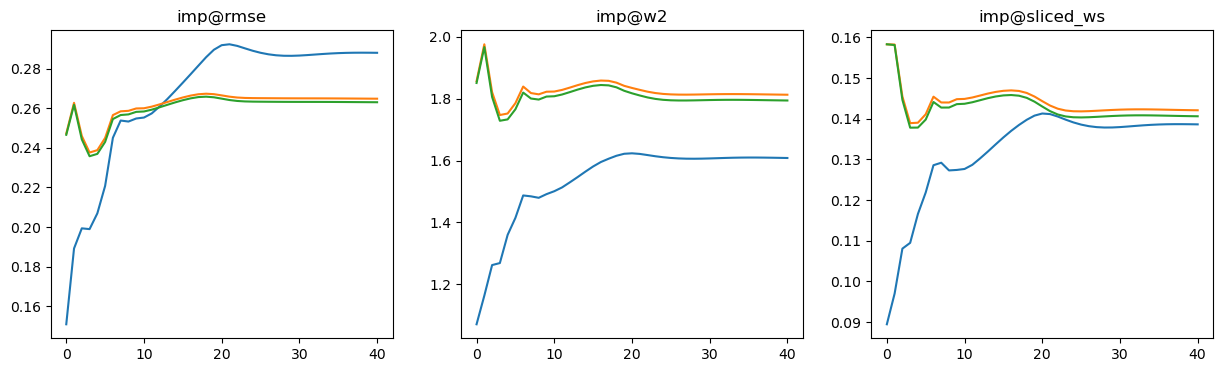

{'imp@rmse': 0.27192915505485, 'imp@ws': 1.7389833677373319, 'imp@sliced_ws': 0.14046797840185635}


In [121]:
name = 'mnar_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [48]:
pred_ret = NN_evaluation(rets['mnar_lr12_savg'], type='fedavg', n_rounds=500)

2023-07-21 15:14:22.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7013, test_f1: 0.7009, val_loss: 0.6206, val_accu: 0.6538, val_f1: 0.6532
2023-07-21 15:15:26.383 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7194, test_f1: 0.7183, val_loss: 0.6293, val_accu: 0.6367, val_f1: 0.6366
2023-07-21 15:16:30.600 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7102, test_f1: 0.7075, val_loss: 0.6333, val_accu: 0.6308, val_f1: 0.6308
2023-07-21 15:17:34.883 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6833, test_f1: 0.6793, val_loss: 0.6418, val_accu: 0.6229, val_f1: 0.6223
2023-07-21 15:18:40.092 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6638, test_f1: 0.658

0.7564021355533436


In [79]:
pred_ret = NN_evaluation(rets['mnar_lr12_savg'], type='centralized', n_rounds=500)

2023-07-22 16:17:49.552 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5076, train_loss: 0.6933 val_accu: 0.4992 val_f1: 0.4478
2023-07-22 16:18:13.159 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7398, train_loss: 0.6201 val_accu: 0.6596 val_f1: 0.6572
2023-07-22 16:18:38.887 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7164, train_loss: 0.6047 val_accu: 0.6875 val_f1: 0.6875
2023-07-22 16:19:04.122 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7052, train_loss: 0.5934 val_accu: 0.6921 val_f1: 0.6912
2023-07-22 16:19:28.981 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6901, train_loss: 0.5852 val_accu: 0.7050 val_f1: 0.7036


0.7822821464120894


### Our

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_right' 'mnar_quantile_right']
(11051, 21)


2023-07-23 10:03:49.616 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 194.76653549994808


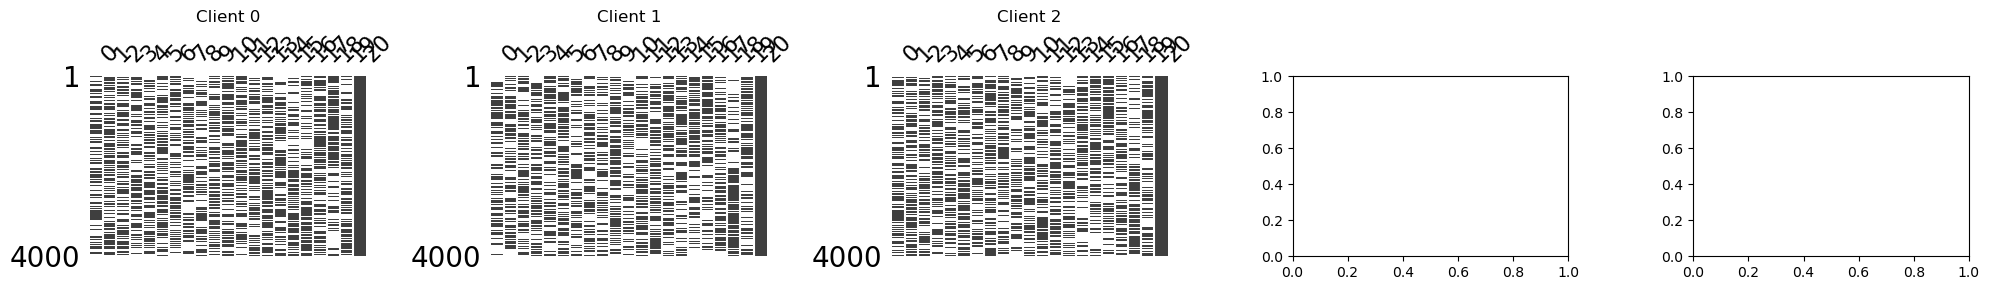

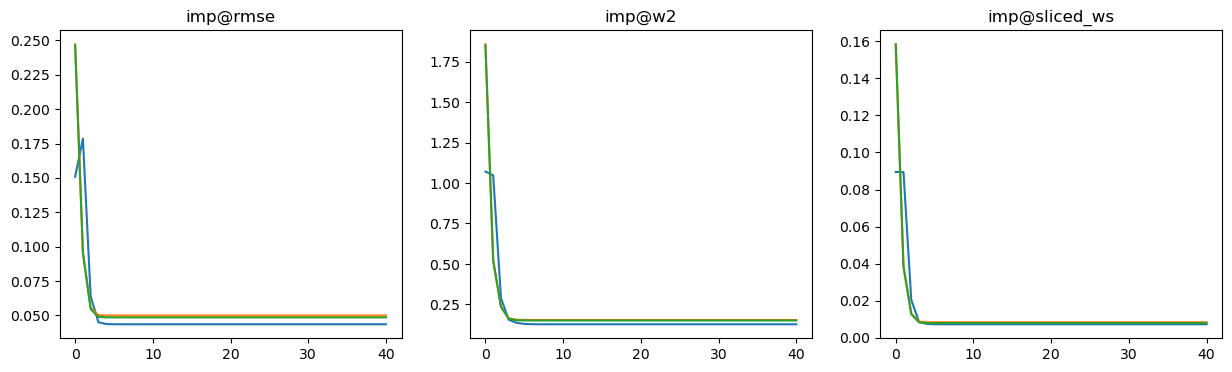

{'imp@rmse': 0.04740248337809446, 'imp@ws': 0.1444007773415774, 'imp@sliced_ws': 0.007926667985850035}


In [122]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = copy.deepcopy(ret)

In [49]:
pred_ret = NN_evaluation(rets['mnar_lr12_fedmechw'], type='fedavg', n_rounds=500)

2023-07-21 15:24:29.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9039, test_f1: 0.9038, val_loss: 0.3605, val_accu: 0.8571, val_f1: 0.8570
2023-07-21 15:25:39.023 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9230, test_f1: 0.9229, val_loss: 0.3335, val_accu: 0.8658, val_f1: 0.8658
2023-07-21 15:26:49.891 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9357, test_f1: 0.9356, val_loss: 0.3110, val_accu: 0.8775, val_f1: 0.8775
2023-07-21 15:28:01.216 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9407, test_f1: 0.9407, val_loss: 0.2987, val_accu: 0.8771, val_f1: 0.8771
2023-07-21 15:29:09.548 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9424, test_f1: 0.942

0.9467921455071939


In [81]:
pred_ret = NN_evaluation(rets['mnar_lr12_fedmechw'], type='centralized', n_rounds=500)

2023-07-22 16:23:27.611 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5434, train_loss: 0.6916 val_accu: 0.5242 val_f1: 0.4696
2023-07-22 16:23:53.295 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.9093, train_loss: 0.3465 val_accu: 0.8621 val_f1: 0.8619
2023-07-22 16:24:19.025 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.9097, train_loss: 0.3107 val_accu: 0.8688 val_f1: 0.8681
2023-07-22 16:24:44.975 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9358, train_loss: 0.2824 val_accu: 0.8862 val_f1: 0.8862
2023-07-22 16:25:10.498 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9348, train_loss: 0.2740 val_accu: 0.8912 val_f1: 0.8911


0.9448918649895937


## MNAR LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 14:42:16.046 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 189.56405170005746


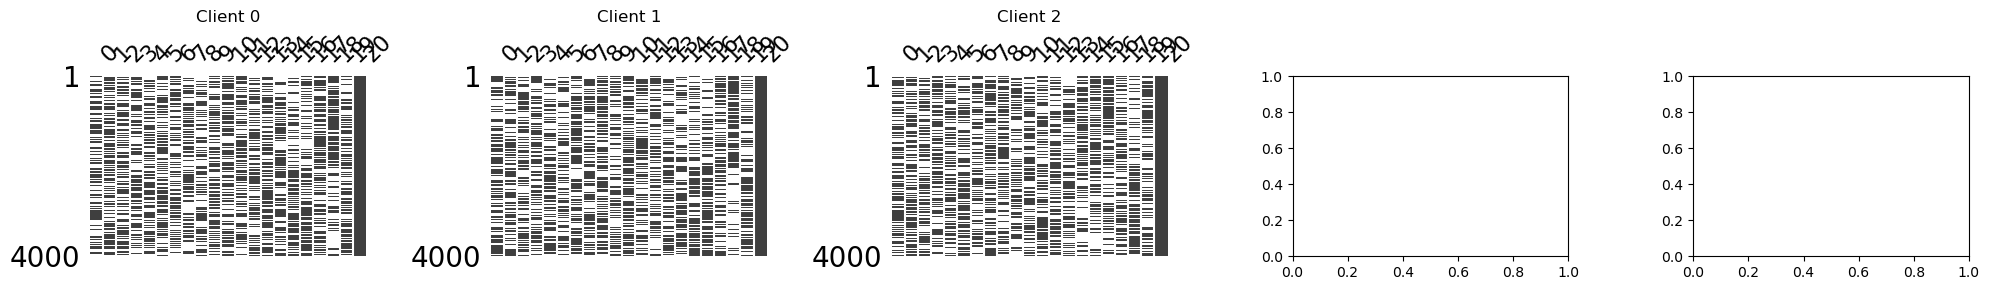

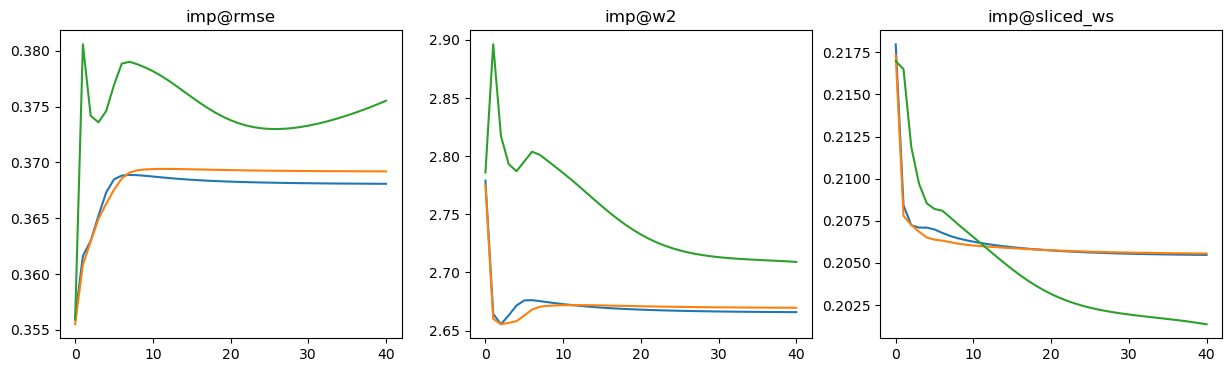

{'imp@rmse': 0.37075334385333625, 'imp@ws': 2.681778370588996, 'imp@sliced_ws': 0.20418210061650308}


In [41]:
name = 'mnar_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [50]:
pred_ret = NN_evaluation(rets['mnar_lr21_local'], type='fedavg', n_rounds=500)

2023-07-21 15:35:42.754 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7057, test_f1: 0.7034, val_loss: 0.6819, val_accu: 0.5679, val_f1: 0.5667
2023-07-21 15:36:47.389 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6931, test_f1: 0.6898, val_loss: 0.7201, val_accu: 0.5558, val_f1: 0.5519
2023-07-21 15:37:53.559 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.6659, test_f1: 0.6589, val_loss: 0.7987, val_accu: 0.5292, val_f1: 0.5211
2023-07-21 15:38:58.729 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6318, test_f1: 0.6201, val_loss: 0.8795, val_accu: 0.5129, val_f1: 0.5025
2023-07-21 15:40:04.747 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6151, test_f1: 0.600

0.7068138629988236


In [83]:
pred_ret = NN_evaluation(rets['mnar_lr21_local'], type='centralized', n_rounds=500)

2023-07-22 16:26:02.267 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5168, train_loss: 0.6935 val_accu: 0.5008 val_f1: 0.4570
2023-07-22 16:26:27.280 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7044, train_loss: 0.6419 val_accu: 0.6404 val_f1: 0.6351
2023-07-22 16:26:53.674 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.6866, train_loss: 0.6368 val_accu: 0.6475 val_f1: 0.6434
2023-07-22 16:27:18.898 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6674, train_loss: 0.6301 val_accu: 0.6592 val_f1: 0.6570
2023-07-22 16:27:44.370 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6566, train_loss: 0.6230 val_accu: 0.6663 val_f1: 0.6642


0.7437335987693421


### Simple Average

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 16:04:23.178 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 202.57688149996102


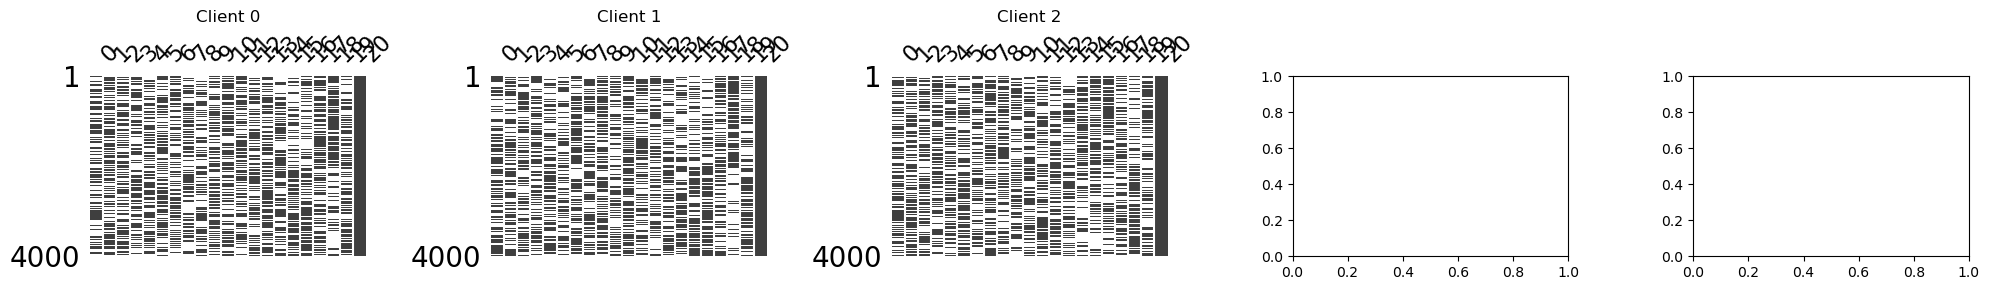

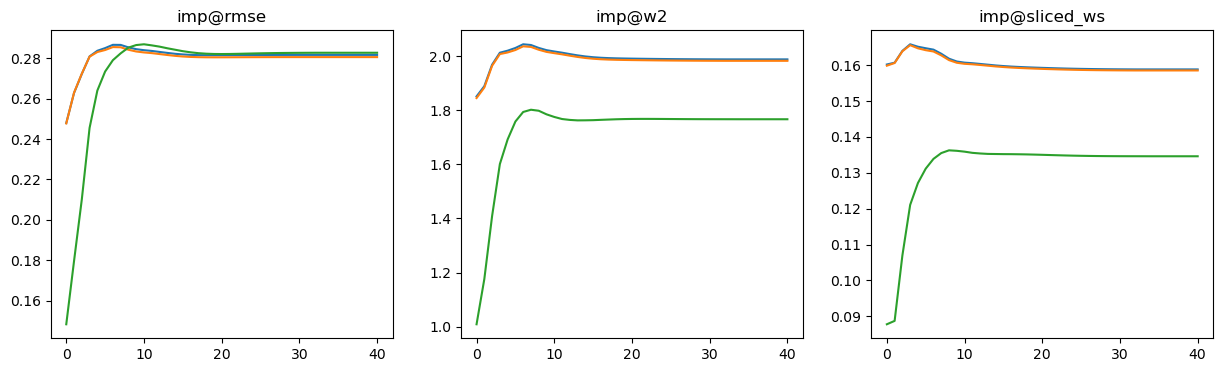

{'imp@rmse': 0.2816484322778277, 'imp@ws': 1.912607595913656, 'imp@sliced_ws': 0.15065309393952486}


In [52]:
name = 'mnar_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [53]:
pred_ret = NN_evaluation(rets['mnar_lr21_savg'], type='fedavg', n_rounds=500)

2023-07-21 16:05:31.770 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7013, test_f1: 0.7009, val_loss: 0.6206, val_accu: 0.6538, val_f1: 0.6532
2023-07-21 16:06:38.344 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7194, test_f1: 0.7183, val_loss: 0.6293, val_accu: 0.6367, val_f1: 0.6366
2023-07-21 16:07:45.812 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7102, test_f1: 0.7075, val_loss: 0.6333, val_accu: 0.6308, val_f1: 0.6308
2023-07-21 16:09:02.896 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.6833, test_f1: 0.6793, val_loss: 0.6418, val_accu: 0.6229, val_f1: 0.6223
2023-07-21 16:10:09.914 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.6638, test_f1: 0.658

0.7564021355533436


In [84]:
pred_ret = NN_evaluation(rets['mnar_lr21_savg'], type='centralized', n_rounds=500)

2023-07-22 16:28:11.712 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5076, train_loss: 0.6933 val_accu: 0.4992 val_f1: 0.4478
2023-07-22 16:28:36.120 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7398, train_loss: 0.6201 val_accu: 0.6596 val_f1: 0.6572
2023-07-22 16:29:01.169 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7164, train_loss: 0.6047 val_accu: 0.6875 val_f1: 0.6875
2023-07-22 16:29:25.641 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7052, train_loss: 0.5934 val_accu: 0.6921 val_f1: 0.6912
2023-07-22 16:29:50.998 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6901, train_loss: 0.5852 val_accu: 0.7050 val_f1: 0.7036


0.7822821464120894


### Our Models

sample {'p': '4000'}
0.15512895094046927 25785
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right']
(11051, 21)


2023-07-21 16:18:20.990 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 197.03045790002216


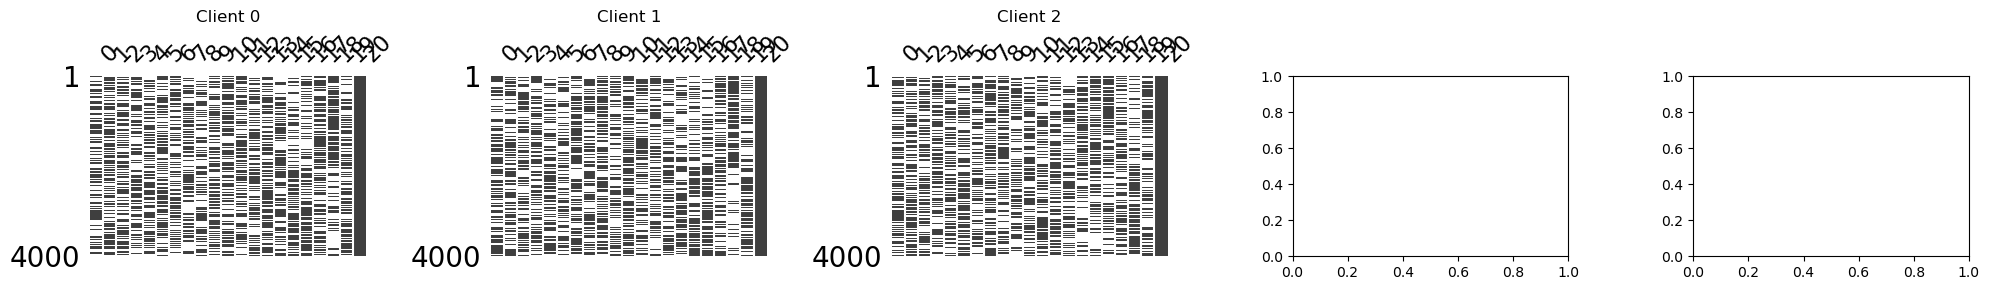

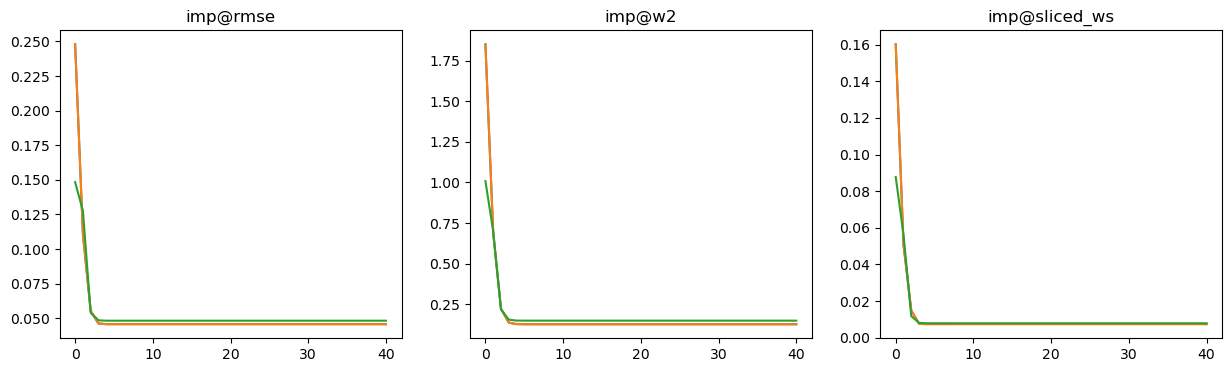

{'imp@rmse': 0.046523048058114615, 'imp@ws': 0.13425840719470056, 'imp@sliced_ws': 0.007581768452353393}


In [54]:
name = 'mnar_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(rets['mnar_lr21_fedmechw'], type='fedavg', n_rounds=500)

2023-07-21 16:19:26.483 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.9039, test_f1: 0.9038, val_loss: 0.3605, val_accu: 0.8571, val_f1: 0.8570
2023-07-21 16:20:29.136 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.9230, test_f1: 0.9229, val_loss: 0.3335, val_accu: 0.8658, val_f1: 0.8658
2023-07-21 16:21:40.737 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.9357, test_f1: 0.9356, val_loss: 0.3110, val_accu: 0.8775, val_f1: 0.8775
2023-07-21 16:22:50.470 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.9407, test_f1: 0.9407, val_loss: 0.2987, val_accu: 0.8771, val_f1: 0.8771
2023-07-21 16:24:00.095 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.9424, test_f1: 0.942

0.9467921455071939


In [85]:
pred_ret = NN_evaluation(rets['mnar_lr21_fedmechw'], type='centralized', n_rounds=500)

2023-07-22 16:30:16.544 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5434, train_loss: 0.6916 val_accu: 0.5242 val_f1: 0.4696
2023-07-22 16:30:41.717 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.9093, train_loss: 0.3465 val_accu: 0.8621 val_f1: 0.8619
2023-07-22 16:31:07.811 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.9097, train_loss: 0.3107 val_accu: 0.8688 val_f1: 0.8681
2023-07-22 16:31:33.832 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.9358, train_loss: 0.2824 val_accu: 0.8862 val_f1: 0.8862
2023-07-22 16:31:59.440 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.9348, train_loss: 0.2740 val_accu: 0.8912 val_f1: 0.8911


0.9448918649895937


## MARY LR 1:2

### Local 

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-23 10:07:09.835 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 185.6972989999922


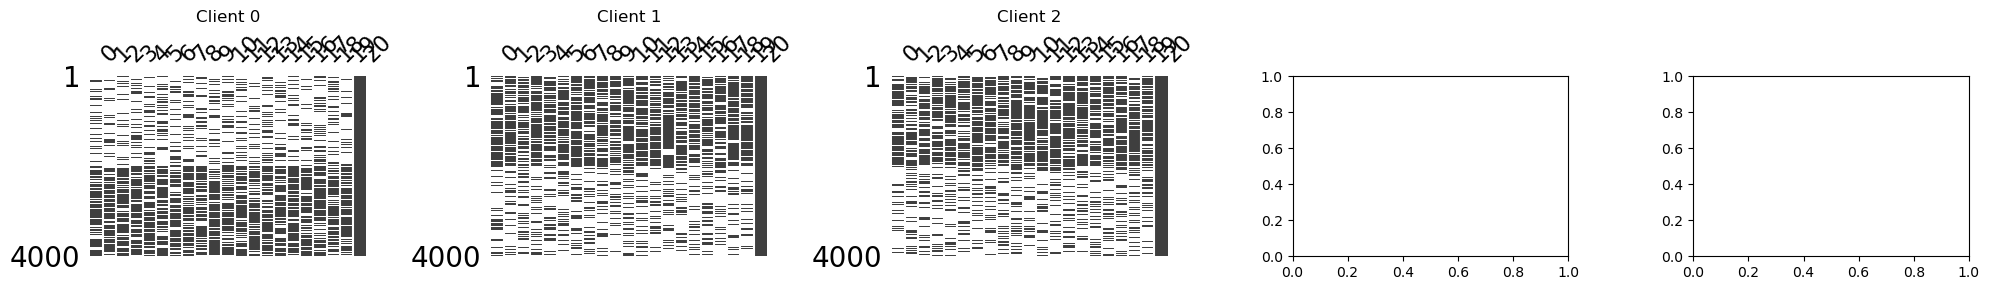

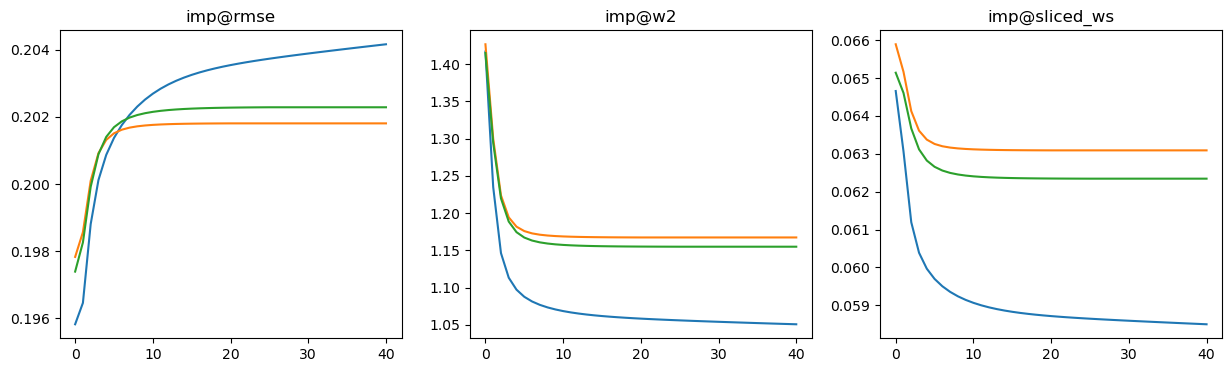

{'imp@rmse': 0.2027357593089986, 'imp@ws': 1.1244705055553461, 'imp@sliced_ws': 0.06131600765196284}


In [123]:
name = 'mary_lr12_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [68]:
pred_ret = NN_evaluation(rets['mary_lr12_local'], type='fedavg', n_rounds=500)

2023-07-21 17:54:25.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7159, test_f1: 0.7014, val_loss: 0.9694, val_accu: 0.5700, val_f1: 0.4818
2023-07-21 17:55:35.106 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7322, test_f1: 0.7313, val_loss: 0.9418, val_accu: 0.5917, val_f1: 0.5242
2023-07-21 17:56:41.232 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7502, test_f1: 0.7501, val_loss: 0.9180, val_accu: 0.6062, val_f1: 0.5484
2023-07-21 17:57:47.598 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7607, test_f1: 0.7587, val_loss: 0.8857, val_accu: 0.6183, val_f1: 0.5698
2023-07-21 17:58:55.189 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7606, test_f1: 0.756

0.7640032576237444


In [86]:
pred_ret = NN_evaluation(rets['mary_lr12_local'], type='centralized', n_rounds=500)

2023-07-22 16:32:24.915 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5234, train_loss: 0.6923 val_accu: 0.5117 val_f1: 0.4182
2023-07-22 16:32:49.465 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.6773, train_loss: 0.5561 val_accu: 0.7117 val_f1: 0.7114
2023-07-22 16:33:14.408 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7225, train_loss: 0.5171 val_accu: 0.7388 val_f1: 0.7355
2023-07-22 16:33:38.953 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7236, train_loss: 0.4773 val_accu: 0.7754 val_f1: 0.7750
2023-07-22 16:34:04.604 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7540, train_loss: 0.4479 val_accu: 0.7850 val_f1: 0.7847


0.8094290109492354


### Simple Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-23 10:10:31.718 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 187.02601140004117


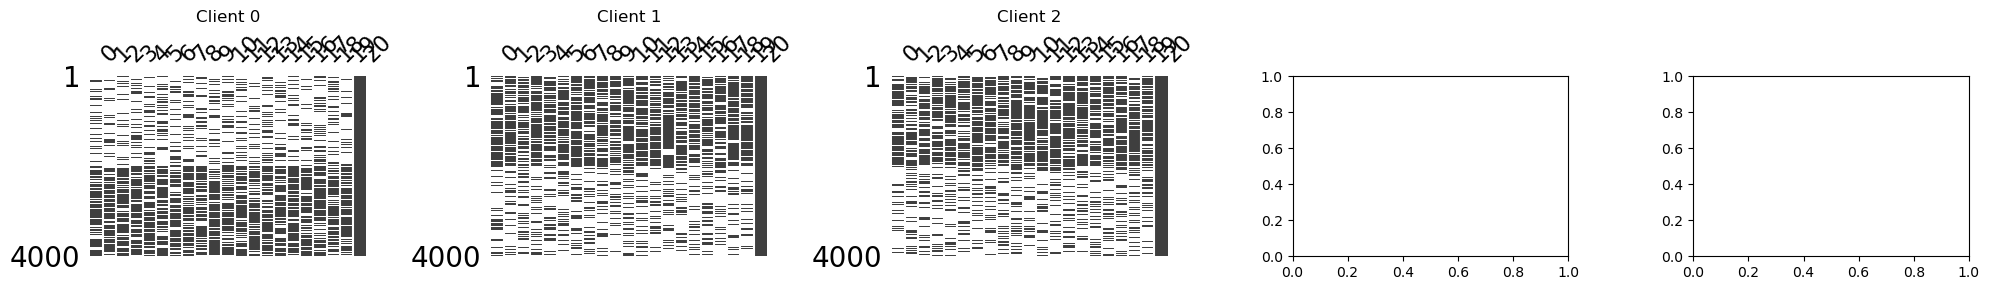

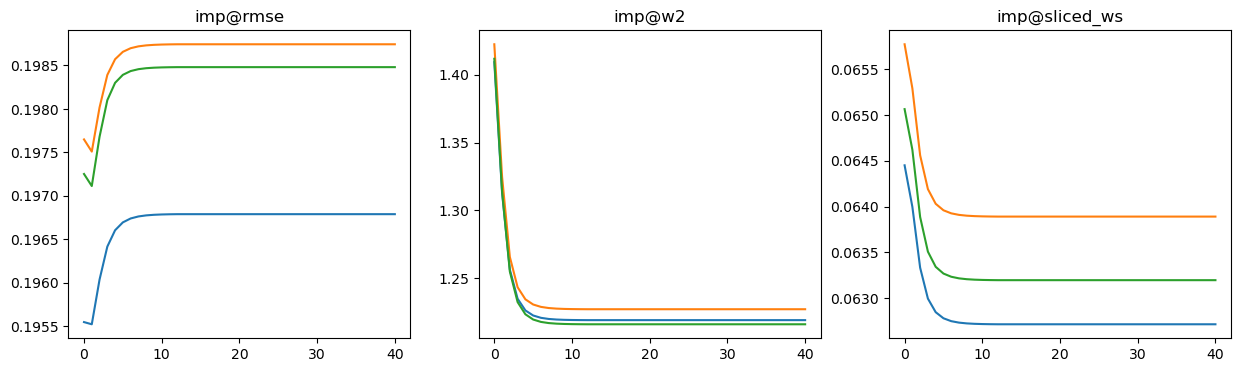

{'imp@rmse': 0.1980047888004091, 'imp@ws': 1.220573151405494, 'imp@sliced_ws': 0.06326677906217326}


In [124]:
name = 'mary_lr12_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [ ]:
pred_ret = NN_evaluation(rets['mary_lr12_savg'], type='fedavg', n_rounds=500)

2023-07-21 18:05:25.125 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8225, test_f1: 0.8222, val_loss: 0.8612, val_accu: 0.6462, val_f1: 0.6051
2023-07-21 18:06:35.976 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8014, test_f1: 0.8002, val_loss: 0.8260, val_accu: 0.6596, val_f1: 0.6274
2023-07-21 18:07:50.800 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7730, test_f1: 0.7697, val_loss: 0.8236, val_accu: 0.6679, val_f1: 0.6403
2023-07-21 18:09:02.748 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7542, test_f1: 0.7477, val_loss: 0.8191, val_accu: 0.6733, val_f1: 0.6480
2023-07-21 18:10:10.529 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7402, test_f1: 0.730

0.8314179712243236


In [87]:
pred_ret = NN_evaluation(rets['mary_lr12_savg'], type='centralized', n_rounds=500)

2023-07-22 16:34:29.737 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5275, train_loss: 0.6921 val_accu: 0.5033 val_f1: 0.3737
2023-07-22 16:34:54.152 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8158, train_loss: 0.5216 val_accu: 0.7454 val_f1: 0.7454
2023-07-22 16:35:19.202 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8603, train_loss: 0.5192 val_accu: 0.7292 val_f1: 0.7244
2023-07-22 16:35:43.380 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8322, train_loss: 0.5144 val_accu: 0.7562 val_f1: 0.7556
2023-07-22 16:36:09.191 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8717, train_loss: 0.5089 val_accu: 0.7396 val_f1: 0.7356


0.881911139263415


### Our Method

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right']
(11051, 21)


2023-07-23 10:13:53.532 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 187.4664463000372


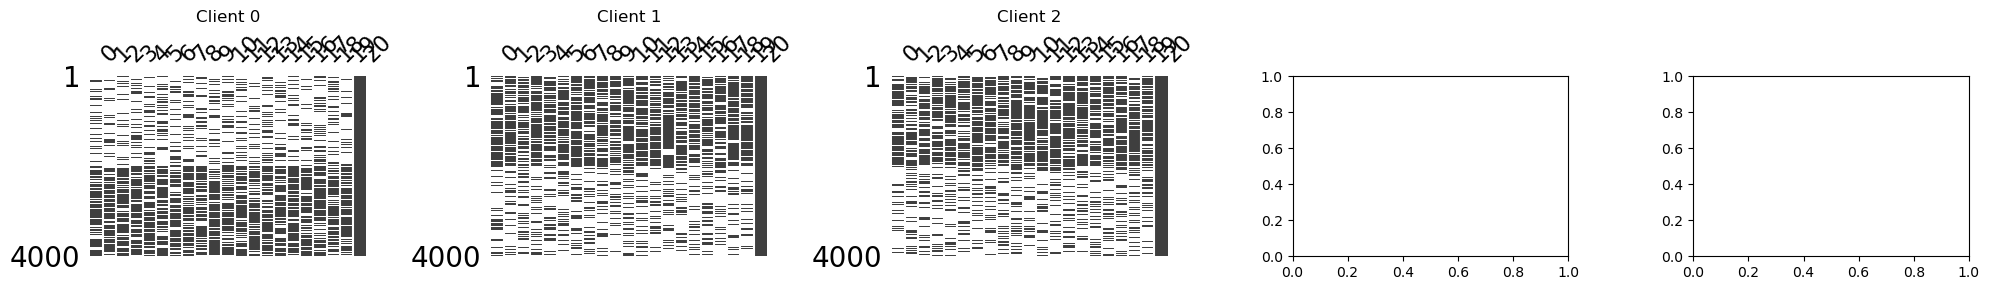

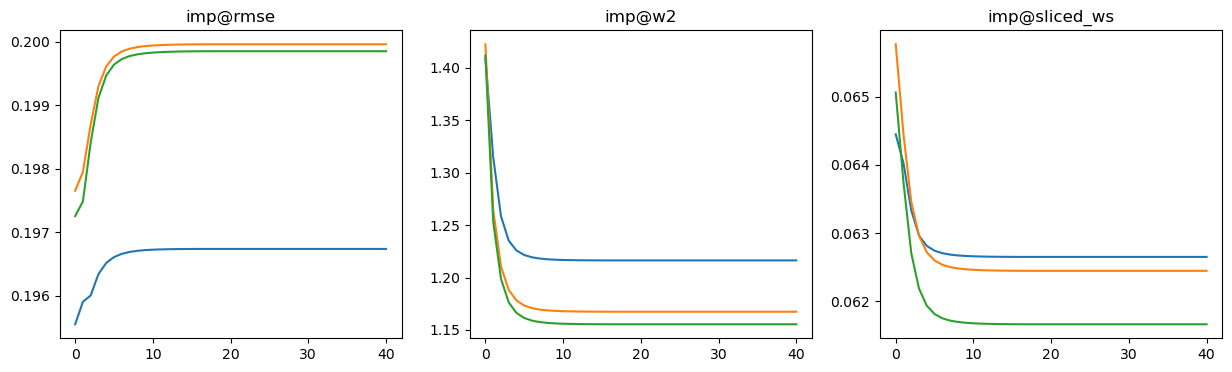

{'imp@rmse': 0.19884651289312663, 'imp@ws': 1.1796854824810687, 'imp@sliced_ws': 0.062251235410251377}


In [125]:
name = 'mary_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.4'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [88]:
pred_ret = NN_evaluation(rets['mary_lr12_fedmechw'], type='fedavg', n_rounds=500)

2023-07-22 16:37:37.071 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8414, test_f1: 0.8412, val_loss: 0.6361, val_accu: 0.6833, val_f1: 0.6635


KeyboardInterrupt: 

In [89]:
pred_ret = NN_evaluation(rets['mary_lr12_fedmechw'], type='centralized', n_rounds=500)

2023-07-22 16:38:26.984 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5352, train_loss: 0.6918 val_accu: 0.5138 val_f1: 0.4181
2023-07-22 16:38:52.576 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8265, train_loss: 0.4441 val_accu: 0.8067 val_f1: 0.8064
2023-07-22 16:39:17.477 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8710, train_loss: 0.4375 val_accu: 0.7425 val_f1: 0.7358
2023-07-22 16:39:42.510 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8702, train_loss: 0.4291 val_accu: 0.7971 val_f1: 0.7967
2023-07-22 16:40:07.404 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8417, train_loss: 0.4255 val_accu: 0.8096 val_f1: 0.8096


0.8797393901004434


## MARY LR 2:1

### Local

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:46:06.402 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 194.28676399996039


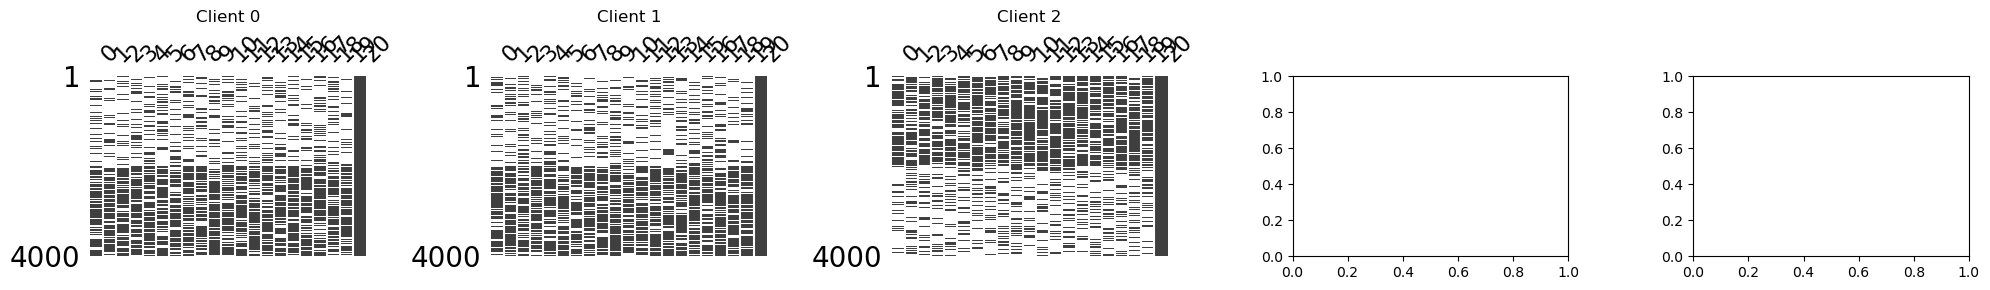

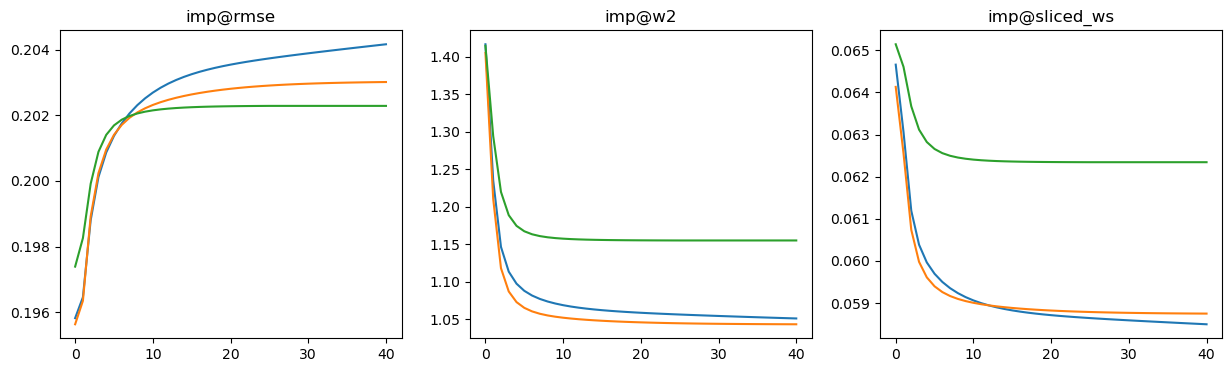

{'imp@rmse': 0.2031361753232303, 'imp@ws': 1.083064002171112, 'imp@sliced_ws': 0.05986985629856001}


In [65]:
name = 'mary_lr21_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [71]:
pred_ret = NN_evaluation(rets['mary_lr21_local'], type='fedavg', n_rounds=500)

2023-07-21 18:26:07.888 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6846, test_f1: 0.6664, val_loss: 0.7347, val_accu: 0.6558, val_f1: 0.6441
2023-07-21 18:27:17.076 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7127, test_f1: 0.7064, val_loss: 0.8727, val_accu: 0.6362, val_f1: 0.6070
2023-07-21 18:28:26.958 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7099, test_f1: 0.7024, val_loss: 0.8672, val_accu: 0.6471, val_f1: 0.6212
2023-07-21 18:29:34.502 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7169, test_f1: 0.7093, val_loss: 0.8771, val_accu: 0.6471, val_f1: 0.6225
2023-07-21 18:30:55.399 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7201, test_f1: 0.710

0.7289838023708262


In [90]:
pred_ret = NN_evaluation(rets['mary_lr21_local'], type='centralized', n_rounds=500)

2023-07-22 16:40:33.143 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5177, train_loss: 0.6927 val_accu: 0.5283 val_f1: 0.4531
2023-07-22 16:40:58.488 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7339, train_loss: 0.6010 val_accu: 0.6808 val_f1: 0.6805
2023-07-22 16:41:22.775 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7297, train_loss: 0.5671 val_accu: 0.6958 val_f1: 0.6943
2023-07-22 16:41:46.792 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7341, train_loss: 0.5278 val_accu: 0.7154 val_f1: 0.7116
2023-07-22 16:42:13.598 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7141, train_loss: 0.4835 val_accu: 0.7642 val_f1: 0.7640


0.857026513437698


### Simpel Averaging

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:49:35.266 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 195.10106639994774


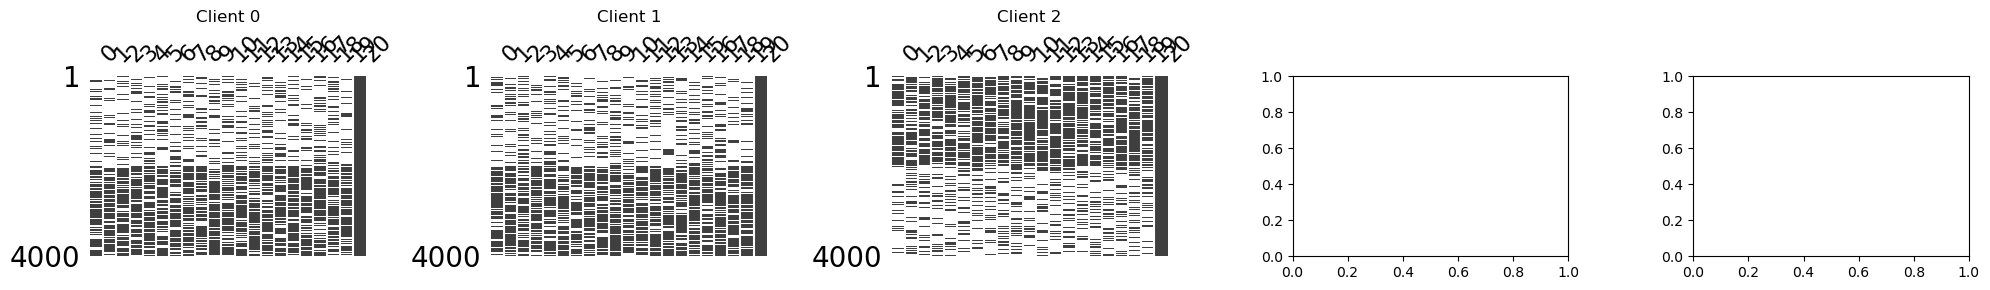

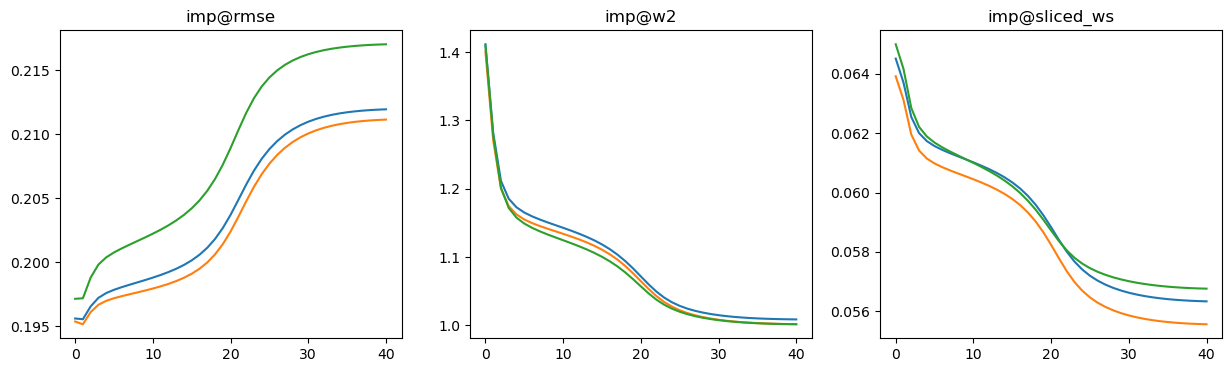

{'imp@rmse': 0.2133232795200905, 'imp@ws': 1.0045175477076904, 'imp@sliced_ws': 0.05623875317618546}


In [66]:
name = 'mary_lr21_savg'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [73]:
pred_ret = NN_evaluation(rets['mary_lr21_savg'], type='fedavg', n_rounds=500)

2023-07-22 06:00:46.915 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7119, test_f1: 0.7045, val_loss: 0.8285, val_accu: 0.6246, val_f1: 0.5816
2023-07-22 06:01:58.141 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7343, test_f1: 0.7303, val_loss: 0.8862, val_accu: 0.6192, val_f1: 0.5724
2023-07-22 06:03:07.549 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7659, test_f1: 0.7656, val_loss: 0.8842, val_accu: 0.6275, val_f1: 0.5848
2023-07-22 06:04:17.139 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7632, test_f1: 0.7632, val_loss: 0.8752, val_accu: 0.6375, val_f1: 0.5983
2023-07-22 06:05:28.205 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7442, test_f1: 0.744

0.7717853587910596


In [77]:
pred_ret = NN_evaluation(rets['mary_lr21_local'], type='centralized', n_rounds=500)

2023-07-22 16:13:03.209 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5177, train_loss: 0.6927 val_accu: 0.5283 val_f1: 0.4531
2023-07-22 16:13:29.983 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7339, train_loss: 0.6010 val_accu: 0.6808 val_f1: 0.6805
2023-07-22 16:13:55.248 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7297, train_loss: 0.5671 val_accu: 0.6958 val_f1: 0.6943
2023-07-22 16:14:20.280 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7341, train_loss: 0.5278 val_accu: 0.7154 val_f1: 0.7116
2023-07-22 16:14:45.687 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7141, train_loss: 0.4835 val_accu: 0.7642 val_f1: 0.7640


0.857026513437698


### Ours

sample {'p': '4000'}
0.15512895094046927 25785
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_right']
(11051, 21)


2023-07-21 17:53:12.442 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 200.54008459998295


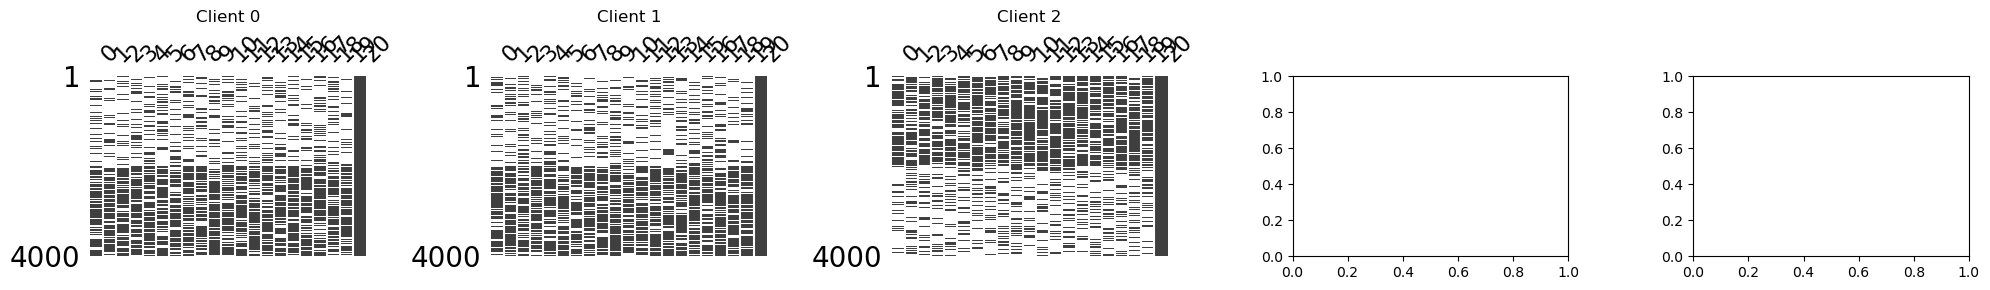

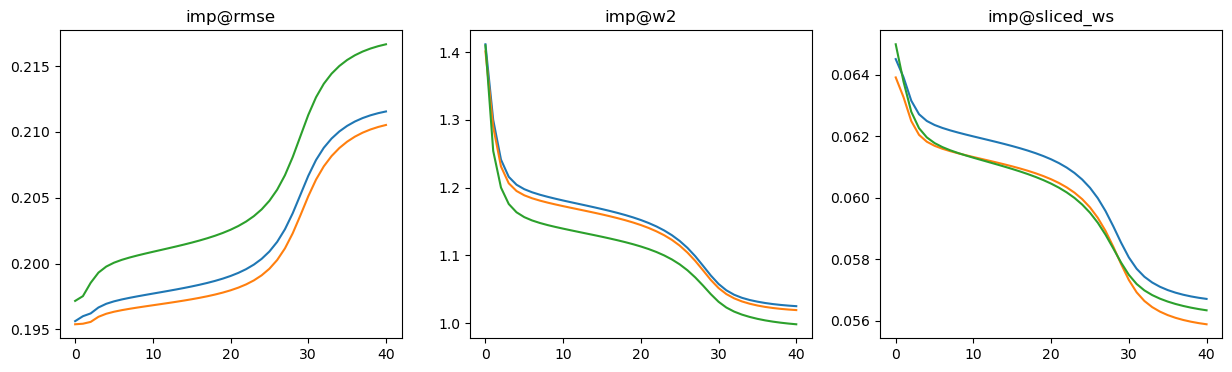

{'imp@rmse': 0.21254775839280676, 'imp@ws': 1.0162330332105207, 'imp@sliced_ws': 0.056399036700184334}


In [67]:
name = 'mary_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.7'
config2['data_partition']['strategy'] = 'sample@p=4000'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [74]:
pred_ret = NN_evaluation(rets['mary_lr21_fedmechw'], type='fedavg', n_rounds=500)

2023-07-22 06:11:41.776 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.7580, test_f1: 0.7567, val_loss: 0.6375, val_accu: 0.6958, val_f1: 0.6846
2023-07-22 06:12:49.123 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.7409, test_f1: 0.7374, val_loss: 0.6449, val_accu: 0.6913, val_f1: 0.6809
2023-07-22 06:13:54.391 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7233, test_f1: 0.7155, val_loss: 0.6021, val_accu: 0.7154, val_f1: 0.7083
2023-07-22 06:14:57.183 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7147, test_f1: 0.7070, val_loss: 0.6020, val_accu: 0.7054, val_f1: 0.6978
2023-07-22 06:16:01.331 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7198, test_f1: 0.714

0.7653606008506018


In [78]:
pred_ret = NN_evaluation(rets['mary_lr21_fedmechw'], type='centralized', n_rounds=500)

2023-07-22 16:15:11.025 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5344, train_loss: 0.6918 val_accu: 0.5487 val_f1: 0.4832
2023-07-22 16:15:36.725 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8206, train_loss: 0.4614 val_accu: 0.8113 val_f1: 0.8112
2023-07-22 16:16:01.856 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7664, train_loss: 0.4468 val_accu: 0.8154 val_f1: 0.8153
2023-07-22 16:16:26.290 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.7447, train_loss: 0.4373 val_accu: 0.8179 val_f1: 0.8175
2023-07-22 16:16:51.677 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.7656, train_loss: 0.4330 val_accu: 0.8163 val_f1: 0.8162


0.8494253913672971


## Visualization of Imputed Data

In [126]:
rets.keys()

dict_keys(['mnar_lr12_local', 'mnar_lr12_savg', 'mnar_lr21_local', 'mnar_lr12_fedmechw', 'mnar_lr21_savg', 'mnar_lr21_fedmechw', 'mary_lr12_local', 'mary_lr12_savg', 'mary_lr12_fedmechw', 'mary_lr21_local', 'mary_lr21_savg', 'mary_lr21_fedmechw'])

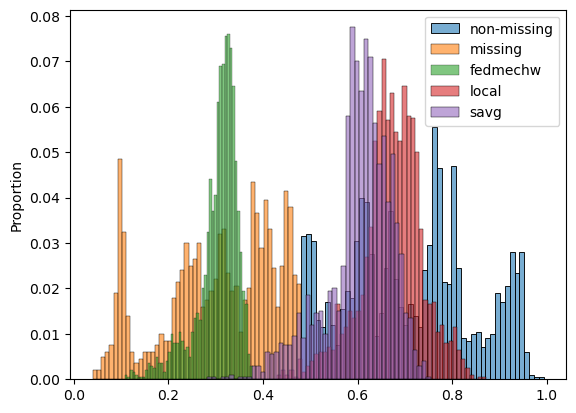

In [128]:
client_id = 0
feature_idx = 0
experiment = 'mnar_lr21'
client_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data'][client_id, ...]
client_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask'][client_id, ...]
client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_imp_data_savg = rets['{}_savg'.format(experiment)]['data']['imputed_data'][client_id,...]
alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()
#client5_imp_data1 = fetch_data(client5_imp_data, feature_idx, q = 0.99)
#sns.histplot(client5_imp_data1, bins = 200)

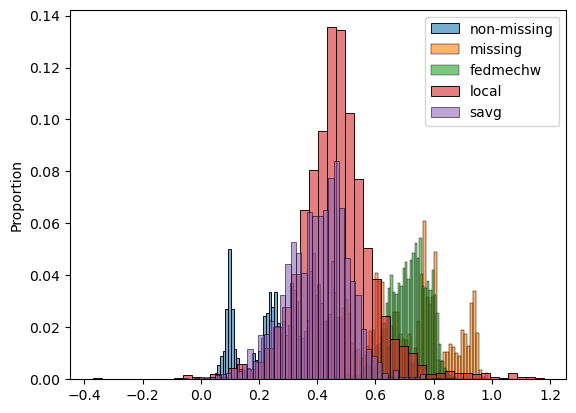

In [130]:
client_id = 2
feature_idx = 0
experiment = 'mnar_lr21'
client_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data'][client_id, ...]
client_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask'][client_id, ...]
client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_imp_data_savg = rets['{}_savg'.format(experiment)]['data']['imputed_data'][client_id,...]
alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

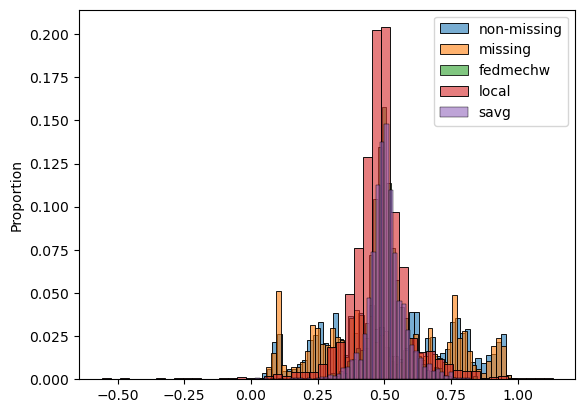

In [132]:
client_id = 0
feature_idx = 0
experiment = 'mary_lr12'
client_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data'][client_id, ...]
client_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask'][client_id, ...]
client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_imp_data_savg = rets['{}_savg'.format(experiment)]['data']['imputed_data'][client_id,...]
alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

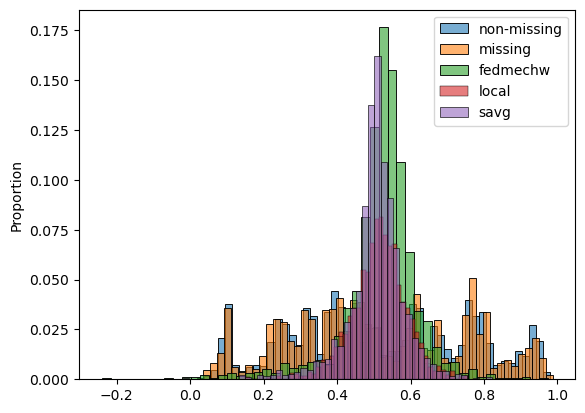

In [134]:
client_id = 1
feature_idx = 0
experiment = 'mary_lr12'
client_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data'][client_id, ...]
client_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask'][client_id, ...]
client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
client_imp_data_savg = rets['{}_savg'.format(experiment)]['data']['imputed_data'][client_id,...]
alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()